<a href="https://colab.research.google.com/github/wjdan-sh/AraBERT-LSTM_Model/blob/main/AraBERT%2BLSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip  install -U farasapy

In [ ]:
from farasa.segmenter import FarasaSegmenter
from farasa.pos import FarasaPOSTagger
from farasa.ner import FarasaNamedEntityRecognizer
from farasa.stemmer import FarasaStemmer
import pandas as pd
import pandas as np

import re
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf


In [ ]:
data = pd.read_csv("/content/cleaned_data.csv")

Bullying:  7510
Non-bullying:  10443


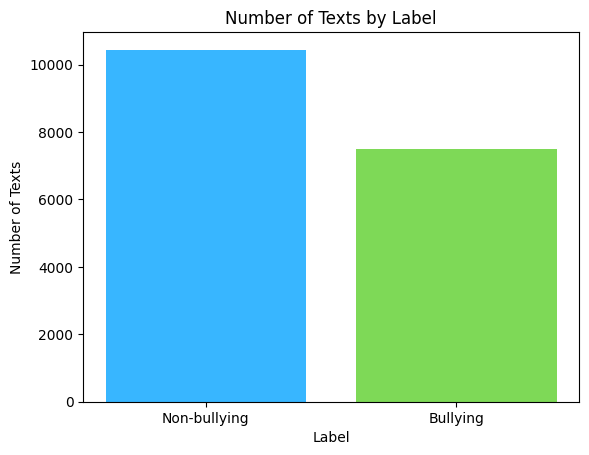

In [ ]:
import matplotlib.pyplot as plt

# Read the data from the CSV file into a DataFrame
data2 = pd.read_csv("/content/cleaned_data.csv")

# Calculate the counts of texts with label 1 and label 0
count_1 = data[data['label'] == 1].shape[0]
count_0 = data[data['label'] == 0].shape[0]


print("Bullying: ", count_1)
print("Non-bullying: ", count_0)

# Create a list of the counts
values = [count_0, count_1]
labels = ['Non-bullying', 'Bullying']

# Plot the data
plt.bar(labels, values, color=['#38B6FF', '#7ED957'])
plt.xlabel('Label')
plt.ylabel('Number of Texts')
plt.title('Number of Texts by Label')
plt.show()

In [ ]:

# Initialize Farasa tools
segmenter = FarasaSegmenter(interactive=True)
stemmer = FarasaStemmer(interactive=True)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'farasa-api.qcri.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


100%|██████████| 241M/241M [04:11<00:00, 959kiB/s] 


[2024-12-02 15:00:20,706 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.
[2024-12-02 15:00:24,730 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


In [ ]:
# 1.1 - Clean the text
def clean_text(text):
    # Check if the value is non-string
    if isinstance(text, float) or isinstance(text, int) or text is None:
        return ''

    # Remove URLs, mentions, hashtags, and numbers
    text = re.sub(r'http\S+|www\S+|https\S+|@[^\s]+|#\S+|\d+', '', text, flags=re.MULTILINE)

    # Remove special characters and punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Remove English characters and numbers
    text = re.sub(r'[a-zA-Z0-9]', '', text)

    return text


In [ ]:
# 1.2 - Normalize the text
def normalize_text(text):
    # Normalize Arabic letters
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("_", " ", text)
    text = re.sub("#", " ", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ة", "ه", text)

    # Remove diacritics (tashkeel, etc.)
    noise = re.compile("""   ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(noise, '', text)

    # Remove repeating characters (like "ههههه" -> "ه")
    text = re.sub(r'(.)\1+', r'\1', text)

    return text


In [ ]:
STOP_WORDS = set([
    "في", "على", "ما", "من", "إلى", "عن", "أن", "لا", "لم", "لن", "به", "فيه",
    "عليه", "عليها", "مع", "هذا", "هذه", "ذلك", "تلك", "هناك", "هنا", "إذ", "إذًا",
    "كان", "كانت", "يكون", "يكونوا", "كنت", "نحن", "هو", "هي", "هم", "أنت", "أنتم",
    "أنا", "لذلك", "لكن", "أو", "و", "ثم", "أي", "فقط", "حتى", "إلا"
])

In [ ]:

# 1.3 - Remove Stop Words
def remove_stop_words(text):
    """Removes common Arabic stop words."""
    tokens = text.split()  # Split text into tokens
    filtered_tokens = [word for word in tokens if word not in STOP_WORDS]
    return ' '.join(filtered_tokens)


In [ ]:
# 1.4 - Preprocess the text using Farasa
def preprocess_with_farasa(text):
    # Clean and normalize the text
    text = clean_text(text)
    text = normalize_text(text)
    text = remove_stop_words(text)  # Remove stop words


    # Segment the text using Farasa
    segmented_text = segmenter.segment(text)

    # Stem the segmented text using Farasa
    stemmed_tokens = [stemmer.stem(word) for word in segmented_text.split()]

    # Join the stemmed tokens back into a single string
    preprocessed_text = ' '.join(stemmed_tokens)

    return preprocessed_text

In [ ]:
# Example usage on a dataset
data["text"] = data["text"].astype(str).apply(preprocess_with_farasa)

# Display the first few rows of the processed dataset
data.head()

,text,label
0,شمس مثقف ه جميل ه وايد حلم هع قال,1
1,حلم ان ي حب ت ها أكثر لان انظلم ت كثير ال ...,0
2,كبرلفك و اله دايضحكون عليج,0
3,و اله كلام ه صحيح شمس,0
4,ذكرى نسي نا ك و ما حد ب أنسى نا صوت ك ال...,0


In [ ]:

X = data['text'].values
y = data['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state = 42)


In [ ]:

tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv2")
model = TFAutoModelForSequenceClassification.from_pretrained("aubmindlab/bert-base-arabertv2", num_labels=2)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/720k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
max_length = 128
# Tokenize training data
train_texts = X_train.tolist()
train_tokenized_texts = tokenizer(train_texts, padding=True, truncation=True, max_length=max_length, return_tensors="tf")

# Tokenize testing data
test_texts = X_test.tolist()
test_tokenized_texts = tokenizer(test_texts, padding=True, truncation=True, max_length=max_length, return_tensors="tf")



In [ ]:

# Extract input IDs and attention masks
train_input_ids = train_tokenized_texts["input_ids"]
train_attention_mask = train_tokenized_texts["attention_mask"]

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]
)

In [ ]:
# Fit the model
model_fit = model.fit({"input_ids": train_input_ids, "attention_mask": train_attention_mask}, y_train, epochs=3, batch_size=32,validation_split=0.1)


Epoch 1/3
404/404 [==============================] - 372s 791ms/step - loss: 0.4188 - accuracy: 0.8053 - val_loss: 0.3626 - val_accuracy: 0.8490
Epoch 2/3
404/404 [==============================] - 332s 821ms/step - loss: 0.2858 - accuracy: 0.8846 - val_loss: 0.3735 - val_accuracy: 0.8455
Epoch 3/3
404/404 [==============================] - 324s 802ms/step - loss: 0.2070 - accuracy: 0.9195 - val_loss: 0.3779 - val_accuracy: 0.8559


In [ ]:
# Tokenize the testing data
test_input_ids = test_tokenized_texts["input_ids"]
test_attention_mask = test_tokenized_texts["attention_mask"]

# Evaluate the model on the test data
evaluation = model.evaluate({"input_ids": test_input_ids, "attention_mask": test_attention_mask}, y_test)

# Print the evaluation results
print("Evaluation results:")
for metric_name, metric_value in zip(model.metrics_names, evaluation):
    print(f"{metric_name}: {metric_value}")

113/113 [==============================] - 33s 294ms/step - loss: 0.3173 - accuracy: 0.8780
Evaluation results:
loss: 0.31731799244880676
accuracy: 0.878028392791748


In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Parameters for LSTM
max_vocab_size = 20000  # Maximum vocabulary size for tokenization
max_sequence_length = 128  # Maximum sequence length (same as AraBERT max_length)
embedding_dim = 128  # Embedding dimensions for LSTM


In [ ]:
# Tokenize the data for the LSTM model
lstm_tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
lstm_tokenizer.fit_on_texts(train_texts)  # Fit tokenizer on training data

lstm_train_sequences = lstm_tokenizer.texts_to_sequences(train_texts)
lstm_test_sequences = lstm_tokenizer.texts_to_sequences(test_texts)


In [ ]:
# Pad sequences to ensure uniform input size
lstm_train_padded = pad_sequences(lstm_train_sequences, maxlen=max_sequence_length, padding="post", truncating="post")
lstm_test_padded = pad_sequences(lstm_test_sequences, maxlen=max_sequence_length, padding="post", truncating="post")


In [ ]:

# Build the LSTM model
lstm_model = Sequential([
    Embedding(max_vocab_size, embedding_dim, input_length=max_sequence_length),
    Bidirectional(LSTM(64, return_sequences=True)),  # Bi-directional LSTM
    GlobalMaxPooling1D(),  # Max pooling for dimensionality reduction
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(2, activation="softmax")  # Output layer for binary classification
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Compile the LSTM model
lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
# Train the LSTM model
lstm_model_fit = lstm_model.fit(
    lstm_train_padded, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1
)


Epoch 1/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5571 - loss: 0.6864 - val_accuracy: 0.5783 - val_loss: 0.6768
Epoch 2/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5861 - loss: 0.6715 - val_accuracy: 0.6138 - val_loss: 0.6546
Epoch 3/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.6743 - loss: 0.6224 - val_accuracy: 0.7411 - val_loss: 0.5461
Epoch 4/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.7734 - loss: 0.5008 - val_accuracy: 0.7731 - val_loss: 0.4741
Epoch 5/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.8346 - loss: 0.3942 - val_accuracy: 0.7975 - val_loss: 0.4341
Epoch 6/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.8830 - loss: 0.3078 - val_accuracy: 0.8017 - val_loss: 0.4321
Epoch 7/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9095 - loss: 0.2480 - val_accuracy: 0.8024 - val_loss: 0.4694
Epoch 8/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9308 - loss: 0.2023 - val_a

In [ ]:
# Evaluate the LSTM model
lstm_evaluation = lstm_model.evaluate(lstm_test_padded, y_test)
print("LSTM Evaluation Results:")
for metric_name, metric_value in zip(lstm_model.metrics_names, lstm_evaluation):
    print(f"{metric_name}: {metric_value}")


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8284 - loss: 0.4838
LSTM Evaluation Results:
loss: 0.4962608218193054
compile_metrics: 0.8279030919075012


In [ ]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

# Step 1: Evaluate the model
lstm_evaluation = lstm_model.evaluate(lstm_test_padded, y_test)
print("LSTM Evaluation Results:")
for metric_name, metric_value in zip(lstm_model.metrics_names, lstm_evaluation):
    print(f"{metric_name}: {metric_value}")

# Step 2: Make predictions
y_pred_probs = lstm_model.predict(lstm_test_padded)

# Step 3: Fix the format mismatch
# If y_test is one-hot encoded, convert it to binary labels
if len(y_test.shape) > 1 and y_test.shape[1] > 1:  # Check if it's one-hot encoded
    y_test_binary = y_test.argmax(axis=1)  # Convert one-hot labels to single-label binary
else:
    y_test_binary = y_test

# Convert predicted probabilities to binary predictions
y_pred_binary = (y_pred_probs > 0.5).astype(int)

# If y_pred_binary is one-hot encoded, flatten it to single-label binary
if len(y_pred_binary.shape) > 1 and y_pred_binary.shape[1] > 1:
    y_pred_binary = y_pred_binary.argmax(axis=1)

# Step 4: Calculate precision, recall, F1-score
precision = precision_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)

# Print the metrics
print("\nAdditional Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Step 5: Print a classification report
print("\nClassification Report:")
print(classification_report(y_test_binary, y_pred_binary))

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8284 - loss: 0.4838
LSTM Evaluation Results:
loss: 0.4962608218193054
compile_metrics: 0.8279030919075012
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Additional Metrics:
Precision: 0.7886
Recall: 0.7992
F1-Score: 0.7939

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      2102
           1       0.79      0.80      0.79      1489

    accuracy                           0.83      3591
   macro avg       0.82      0.82      0.82      3591
weighted avg       0.83      0.83      0.83      3591



In [ ]:
# Evaluate LSTM
lstm_evaluation = lstm_model.evaluate(lstm_test_padded, y_test)
print("LSTM Evaluation Results:")
for metric_name, metric_value in zip(lstm_model.metrics_names, lstm_evaluation):
    print(f"{metric_name}: {metric_value}")


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8284 - loss: 0.4838
LSTM Evaluation Results:
loss: 0.4962608218193054
compile_metrics: 0.8279030919075012


In [ ]:
# Ensemble predictions
arabert_predictions = model.predict({"input_ids": test_input_ids, "attention_mask": test_attention_mask}).logits
arabert_probs = tf.nn.softmax(arabert_predictions, axis=1).numpy()
lstm_predictions = lstm_model.predict(lstm_test_padded)
ensemble_probs = (0.7 * arabert_probs) + (0.3 * lstm_predictions)


113/113 [==============================] - 36s 283ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [ ]:
import numpy as np

ensemble_predictions = np.argmax(ensemble_probs, axis=1)

In [ ]:
# Evaluate ensemble
ensemble_accuracy = np.sum(ensemble_predictions == y_test) / len(y_test)
print(f"Ensemble Accuracy: {ensemble_accuracy}")


Ensemble Accuracy: 0.8835978835978836


In [ ]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, ensemble_predictions))


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      2102
           1       0.85      0.87      0.86      1489

    accuracy                           0.88      3591
   macro avg       0.88      0.88      0.88      3591
weighted avg       0.88      0.88      0.88      3591



In [ ]:
# Ensemble predictions
arabert_predictions = model.predict({"input_ids": test_input_ids, "attention_mask": test_attention_mask}).logits
arabert_probs = tf.nn.softmax(arabert_predictions, axis=1).numpy()
lstm_predictions = lstm_model.predict(lstm_test_padded)
ensemble_probs = (0.7 * arabert_probs) + (0.3 * lstm_predictions)

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

ensemble_predictions = np.argmax(ensemble_probs, axis=1)

# Evaluate ensemble
ensemble_accuracy = np.sum(ensemble_predictions == y_test) / len(y_test)
print(f"Ensemble Accuracy: {ensemble_accuracy}")

# Additional metrics
precision = precision_score(y_test, ensemble_predictions, average='weighted')
recall = recall_score(y_test, ensemble_predictions, average='weighted')
f1 = f1_score(y_test, ensemble_predictions, average='weighted')

# Print the metrics
print("\nAdditional Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Classification report
from sklearn.metrics import classification_report

print("\nClassification Report:")
print(classification_report(y_test, ensemble_predictions))

113/113 [==============================] - 32s 283ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Ensemble Accuracy: 0.8835978835978836

Additional Metrics:
Precision: 0.8842
Recall: 0.8836
F1-Score: 0.8838

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      2102
           1       0.85      0.87      0.86      1489

    accuracy                           0.88      3591
   macro avg       0.88      0.88      0.88      3591
weighted avg       0.88      0.88      0.88      3591



In [ ]:
text_to_test = "غثييييييثة لأبعد حد وكريهه "
arabert_tokenized_text = tokenizer(text_to_test, padding="max_length", truncation=True, max_length=max_length, return_tensors="tf")
lstm_text_sequence = lstm_tokenizer.texts_to_sequences([text_to_test])
lstm_text_padded = pad_sequences(lstm_text_sequence, maxlen=max_sequence_length, padding="post", truncating="post")

# Get predictions for the new text
arabert_test_pred = model.predict({"input_ids": arabert_tokenized_text["input_ids"], "attention_mask": arabert_tokenized_text["attention_mask"]})
lstm_test_pred = lstm_model.predict(lstm_text_padded)

# Calculate ensemble prediction for the new text
arabert_test_probs = tf.nn.softmax(arabert_test_pred.logits, axis=1).numpy()
lstm_test_probs = np.array(lstm_test_pred)
ensemble_test_probs = (0.7 * arabert_test_probs) + (0.3 * lstm_test_probs)
ensemble_test_pred_class = np.argmax(ensemble_test_probs, axis=1)[0]

# Print the result
if ensemble_test_pred_class == 0:
    print("النص لا يحتوي على تنمر.")
else:
    print("النص يحتوي على محتوى للتنمر.")

1/1 [==============================] - 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
النص يحتوي على محتوى للتنمر.


In [ ]:
text_to_test = "  الله يهديك بس و يشغلك بطاعته"
arabert_tokenized_text = tokenizer(text_to_test, padding="max_length", truncation=True, max_length=max_length, return_tensors="tf")
lstm_text_sequence = lstm_tokenizer.texts_to_sequences([text_to_test])
lstm_text_padded = pad_sequences(lstm_text_sequence, maxlen=max_sequence_length, padding="post", truncating="post")

# Get predictions for the new text
arabert_test_pred = model.predict({"input_ids": arabert_tokenized_text["input_ids"], "attention_mask": arabert_tokenized_text["attention_mask"]})
lstm_test_pred = lstm_model.predict(lstm_text_padded)

# Calculate ensemble prediction for the new text
arabert_test_probs = tf.nn.softmax(arabert_test_pred.logits, axis=1).numpy()
lstm_test_probs = np.array(lstm_test_pred)
ensemble_test_probs = (0.7 * arabert_test_probs) + (0.3 * lstm_test_probs)
ensemble_test_pred_class = np.argmax(ensemble_test_probs, axis=1)[0]

# Print the result
if ensemble_test_pred_class == 0:
    print("النص لا يحتوي على تنمر.")
else:
    print("النص يحتوي على محتوى للتنمر.")

1/1 [==============================] - 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
النص لا يحتوي على تنمر.


In [ ]:
# List of texts to test
texts_to_test = [
    "الله يهديك بس ولا يشغلك الا بطاعته",
    "أنت شخص غبي للغاية",
    "كلامك جميل ومفيد",
    "يا قبيح، محد يحبك",
    "ما شاء الله، عمل رائع!",
    "حمار انت وش ها الغباء",
    "يا زينك ما شاء الله، كلامك يدخل القلب على طول.",
    "أنت فاشل بكل شي، لا تتعب نفسك حتى تحاول.",
    "الله يوفقك في شغلك الجديد، تستاهل كل خير.",
    "ياخي أنت دايم تخلي الواحد يضحك، روحك حلوة.",
    "ما شاء الله عليك، شغلك كله إبداع وذوق.",
    "ربي يرزقك السعادة وراحة البال، تستاهل كل خير.",
    "شكلك اليوم كأنك ما نمت من أسبوع، وش فيك؟",
    "ياخي أنت غبي، كم مرة أشرح لك نفس الشي؟",
    "غثييييييثة لأبعد حد وكريه"
]
# Loop through each text
for text_to_test in texts_to_test:
    # Tokenize for AraBERT
    arabert_tokenized_text = tokenizer(
        text_to_test,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )

    # Tokenize and pad for LSTM
    lstm_text_sequence = lstm_tokenizer.texts_to_sequences([text_to_test])
    lstm_text_padded = pad_sequences(
        lstm_text_sequence,
        maxlen=max_sequence_length,
        padding="post",
        truncating="post"
    )

    # Get predictions for AraBERT
    arabert_test_pred = model.predict({
        "input_ids": arabert_tokenized_text["input_ids"],
        "attention_mask": arabert_tokenized_text["attention_mask"]
    })

    # Get predictions for LSTM
    lstm_test_pred = lstm_model.predict(lstm_text_padded)

    # Calculate ensemble prediction
    arabert_test_probs = tf.nn.softmax(arabert_test_pred.logits, axis=1).numpy()
    lstm_test_probs = np.array(lstm_test_pred)
    ensemble_test_probs = (0.7 * arabert_test_probs) + (0.3 * lstm_test_probs)
    ensemble_test_pred_class = np.argmax(ensemble_test_probs, axis=1)[0]

    # Print the result for each text
    if ensemble_test_pred_class == 0:
        print(f"النص: \"{text_to_test}\" -> لا يحتوي على تنمر.")
    else:
        print(f"النص: \"{text_to_test}\" -> يحتوي على محتوى للتنمر.")

1/1 [==============================] - 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
النص: "الله يهديك بس ولا يشغلك الا بطاعته" -> لا يحتوي على تنمر.
1/1 [==============================] - 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
النص: "أنت شخص غبي للغاية" -> يحتوي على محتوى للتنمر.
1/1 [==============================] - 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
النص: "كلامك جميل ومفيد" -> لا يحتوي على تنمر.
1/1 [==============================] - 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
النص: "يا قبيح، محد يحبك" -> يحتوي على محتوى للتنمر.
1/1 [==============================] - 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
النص: "ما شاء الله، عمل رائع!" -> لا يحتوي على تنمر.
1/1 [==============================] - 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
النص: "حمار انت وش ها الغباء" -> يحتوي على محتوى للتنمر.
1/1 [==============================] - 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
النص: "يا زينك ما شاء الله، كلامك يدخل ال

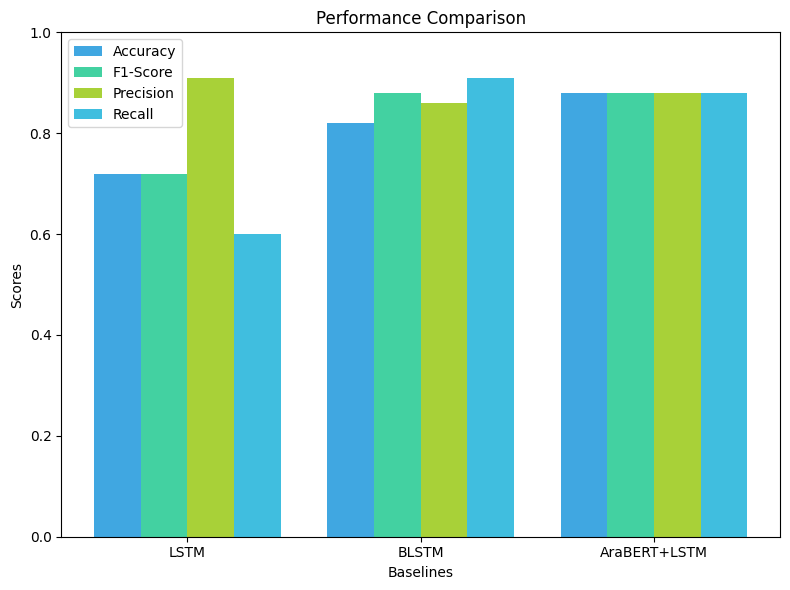

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the labels and values for the bar graph
approaches = ['LSTM', 'BLSTM', 'AraBERT+LSTM']
accuracies = [0.72, 0.82, 0.88]
f1_scores = [0.72, 0.88, 0.88]
precisions = [0.91, 0.86, 0.88]
recalls = [0.60, 0.91, 0.88]

# Set the width of the bars
bar_width = 0.2
index = np.arange(len(approaches))

# Create subplots for each metric
fig, ax = plt.subplots(figsize=(8, 6))
bar1 = ax.bar(index, accuracies, bar_width, label='Accuracy', color='#40a7e1')
bar2 = ax.bar(index + bar_width, f1_scores, bar_width, label='F1-Score', color='#43d1a1')
bar3 = ax.bar(index + 2 * bar_width, precisions, bar_width, label='Precision', color='#a8d138')
bar4 = ax.bar(index + 3 * bar_width, recalls, bar_width, label='Recall', color='#40bedf')

# Add labels, title, and legend
ax.set_xlabel('Baselines')
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels(approaches)
ax.legend()

# Display the graph
plt.ylim(0, 1)  # Set the y-axis limits from 0 to 1 for metrics
plt.tight_layout()
plt.show()


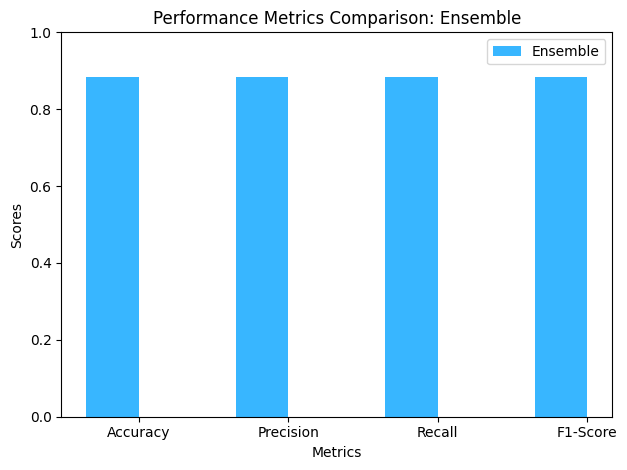

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the metrics and their values for each approach
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
ensemble_metrics = [ensemble_accuracy, precision, recall, f1]
#baseline_metrics = [baseline_accuracy, baseline_precision, baseline_recall, baseline_f1]

# Set the width of the bars
bar_width = 0.35
index = np.arange(len(metrics))

# Create the grouped bar chart
fig, ax = plt.subplots()
bar1 = ax.bar(index - bar_width/2, ensemble_metrics, bar_width, label='Ensemble', color='#38B6FF')
#bar2 = ax.bar(index + bar_width/2, baseline_metrics, bar_width, label='Baseline', color='lightcoral')

# Add labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics Comparison: Ensemble')
ax.set_xticks(index)
ax.set_xticklabels(metrics)
ax.legend()

# Display the grouped bar chart
plt.ylim(0, 1)  # Set the y-axis limits from 0 to 1 for accuracy
plt.tight_layout()
plt.show()